Preprocess archive.zip

In [ ]:
!python3 preprocess.py

Import libraries

In [12]:
import pymongo
import json
import os
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

Connect to MongoDB

In [6]:
client = pymongo.MongoClient("localhost", 27017)

Create database and collections

In [7]:
db = client["my_db"]
collection_cat = db['youtube_categories']
collection_vids = db['videos_data']

Insert json files to collections

In [ ]:
# Iterate through the json files in the "data" directory
for filename in os.listdir("data/"):
    print(f'Inserting {filename}...')
    filename = 'data/' + filename
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'category' in filename:

        collection_cat.insert_many(data["items"])
        
    else:
        # Insert the json documents into the collection
        
        collection_vids.insert_many(data)

print("Done.")

Task 1: 

Task 2:

Task 3:

Task 4:

Task 5:

Task 6: 

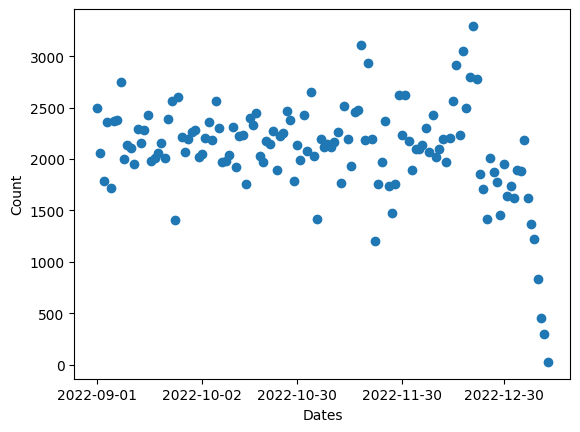

In [13]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$project': {
            'date': {
                '$dateToString': {
                    'format': '%Y-%m-%d', 
                    'date': {
                        '$convert': {
                            'input': '$publishedAt', 
                            'to': 'date'
                        }
                    }
                }
            }, 
            'video_id': 1, 
            'title': 1, 
            'country': 'GB'
        }
    }, {
        '$match': {
            'date': {
                '$gte': '2022-09-01'
            }
        }
    }, {
        '$group': {
            '_id': '$date', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }, {
        '$project': {
            'date': '$_id', 
            'count': 1, 
            '_id': 0
        }
    }
])

# 'result' is an iterator object!
x_values = []
y_values = []
for item in result:
    x_values.append(item['date'])
    y_values.append(item['count'])

plt.scatter(x_values, y_values)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Dates')
plt.ylabel('Count')
plt.show()